In [14]:
import pandas as pd
import seaborn as sns
import geopandas as gpd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.geometry import box
import contextily as ctx
import esda
import scipy as sp
from pysal.lib import  weights
from splot.esda import moran_scatterplot, lisa_cluster
from splot.libpysal import plot_spatial_weights

In [15]:
dfEmissioniTGEO=pd.read_pickle("Dataset/EmissioniTGEO.pickle")
dfEmissioniProCapGEO=pd.read_pickle("Dataset/EmissioniProCapGEO.pickle")
dfEmissioniTempoT=pd.read_pickle("Dataset/EmissioniTempoT.pickle")
dfEmissioniTempoProCap=pd.read_pickle("Dataset/EmissioniTempoProCap.pickle")
dfEmissioniPerPaeseStorico=pd.read_csv("Dataset/EmissioniPerPaeseStorico.csv")
gdfNazioni=gpd.read_file("Dataset/CNTR_RG_60M_2024_4326.gpkg")
gdfNazioni.drop(['CNTR_NAME', 'NAME_ENGL', 'NAME_FREN', 'ISO3_CODE',
       'SVRG_UN', 'CAPT', 'EU_STAT', 'EFTA_STAT', 'CC_STAT', 'NAME_GERM'],axis=1,inplace=True)
gdfDensità=pd.read_pickle("Dataset/Densità.pickle")

In [16]:
gdfEmissioniTGEO=gpd.GeoDataFrame(dfEmissioniTGEO.merge(gdfNazioni, left_on="geo", right_on="CNTR_ID"), geometry="geometry", crs=gdfNazioni.crs)
gdfEmissioniProCapGEO=gpd.GeoDataFrame(dfEmissioniProCapGEO.merge(gdfNazioni, left_on="geo", right_on="CNTR_ID"), geometry="geometry", crs=gdfNazioni.crs)

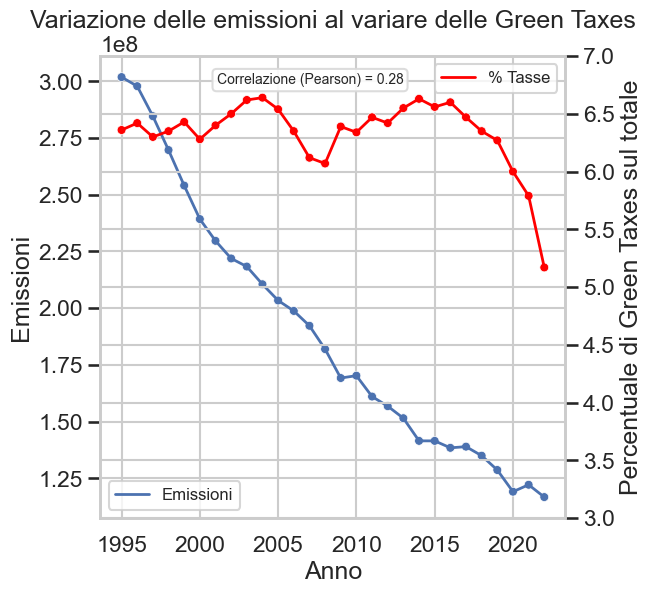

In [17]:
sns.set_theme(style="whitegrid")
sns.set_context("talk")
correlazione, p=sp.stats.pearsonr(dfEmissioniTempoT['PERC_TASSE'],dfEmissioniTempoT['EmissioniAnno'])
fig, axes = plt.subplots( figsize=(6,6))
axes2=axes.twinx()
sns.scatterplot(x='TIME_PERIOD',y="EmissioniAnno",data=dfEmissioniTempoT, ax=axes, size=1,legend=False)
sns.lineplot(x='TIME_PERIOD',y="EmissioniAnno",data=dfEmissioniTempoT, ax=axes, linewidth=2,label="Emissioni", errorbar=None)
sns.scatterplot(x='TIME_PERIOD',y="PERC_TASSE",data=dfEmissioniTempoT, ax=axes2,color='red', size=1, legend=False)
sns.lineplot(x='TIME_PERIOD',y="PERC_TASSE",data=dfEmissioniTempoT, ax=axes2, color='red', linewidth=2,label="% Tasse",errorbar=None)
axes.set_title("Variazione delle emissioni al variare delle Green Taxes")
axes.set_xlabel('Anno')
axes.set_ylabel('Emissioni')
axes2.set_ylabel('Percentuale di Green Taxes sul totale')
axes2.set_ylim(3,7)
axes.legend(loc="lower left",fontsize=12)
axes2.legend(loc="upper right", fontsize=12)
txt=txt = f"Correlazione (Pearson) = {correlazione:.2f}"
fig.text(
    0.63, 0.84, txt , ha="right", va="center", fontsize=10,
    bbox=dict(boxstyle="round", fc="white", ec="0.85", alpha=0.9)
)
plt.savefig("Grafici/graficoVARtasseVARemissioni.svg", format='svg')

In [18]:
gdfEmissioniTGEO["Area"]=gdfEmissioniTGEO.to_crs(epsg=32632).area / 10**6

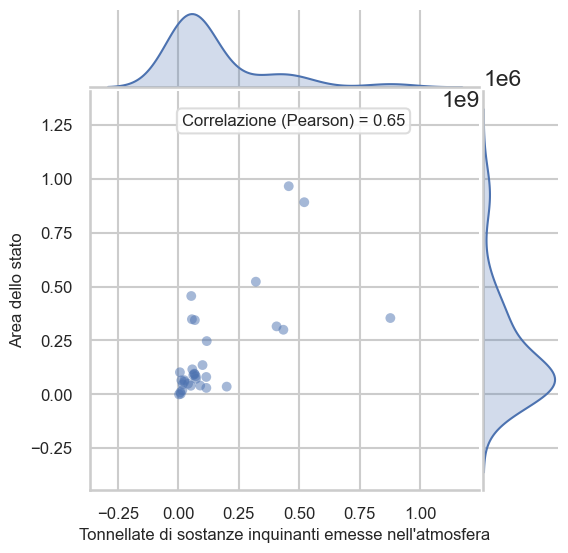

In [19]:
g = sns.JointGrid(data=gdfEmissioniTGEO, x="T", y="Area", height=6, ratio=5, space=0.05)
g.plot_joint(sns.scatterplot, s=50, alpha=0.5, edgecolor="none", color="C0")
sns.kdeplot(data=gdfEmissioniTGEO, x="T",   ax=g.ax_marg_x, fill=True, alpha=0.25, color="C0")
sns.kdeplot(data=gdfEmissioniTGEO, y="Area", ax=g.ax_marg_y, fill=True, alpha=0.25, color="C0")

correlazione,p=sp.stats.pearsonr(gdfEmissioniTGEO["T"],gdfEmissioniTGEO['Area'])
txt = f"Correlazione (Pearson) = {correlazione:.2f}"
g.fig.text(
    0.7, 0.77, txt, ha="right", va="center", fontsize=12,
    bbox=dict(boxstyle="round", fc="white", ec="0.85", alpha=0.9)
)
g.ax_joint.set_xlabel("Tonnellate di sostanze inquinanti emesse nell'atmosfera", fontsize=12)
g.ax_joint.set_ylabel("Area dello stato", fontsize=12)
g.ax_joint.tick_params(labelsize=12)
g.ax_marg_x.tick_params(labelsize=12)
g.ax_marg_y.tick_params(labelsize=12)
g.ax_marg_x.set_ylabel(""); g.ax_marg_x.set_yticks([])
g.ax_marg_y.set_xlabel(""); g.ax_marg_y.set_xticks([])
g.ax_joint.xaxis.get_offset_text().set_visible(False)
g.ax_joint.yaxis.get_offset_text().set_visible(False)
plt.savefig("Grafici/Area-T.svg",format="svg")

In [20]:
mask = gpd.GeoSeries([box(-25, 35, 50, 72)], crs="EPSG:4326")
gdfEmissioniTGEO = gdfEmissioniTGEO[gdfEmissioniTGEO.intersects(mask.iloc[0])].copy()
gdfEmissioniTGEO["geometry"] = gdfEmissioniTGEO.geometry.intersection(mask.iloc[0])



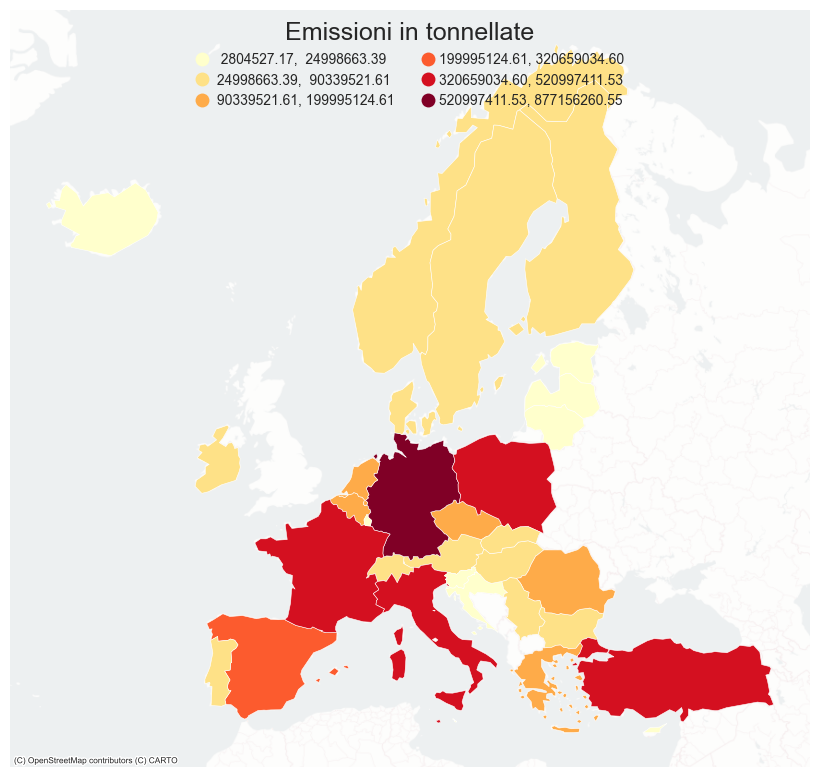

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
g = gdfEmissioniTGEO.to_crs(3857).plot(
    column="T",
    scheme="fisher_jenks", 
    k=6,
    cmap="YlOrRd",                
    linewidth=0.4, edgecolor="white",
    legend=True, ax=ax,
    legend_kwds=dict(
        title="Emissioni in tonnellate",
        loc="upper center",
        frameon=False,
        ncol=2,
        fontsize=10,          
        handlelength=0.8,     
        handletextpad=0.4,    
        borderpad=0.4,        
        labelspacing=0.5     
    ),
    missing_kwds=dict(color="#f0f0f0", edgecolor="lightgray",
                      hatch="///", label="Dati mancanti")
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels,
                alpha=0.4,   
                attribution_size=6)

ax.set_axis_off()
leg = ax.get_legend()
leg.get_frame().set_linewidth(2)  
ax.margins(0)
ax.set_position([0,0,1,1])          
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.savefig("Grafici/EmissioniFisherJenks.svg",format="svg")

In [13]:
w=weights.Queen.from_dataframe(gdfEmissioniTGEO,ids=gdfEmissioniTGEO.index)
gdfEmissioniTGEO['T_STD']=(gdfEmissioniTGEO['T']-gdfEmissioniTGEO['T'].mean())/gdfEmissioniTGEO['T'].std()
gdfEmissioniTGEOMetric=gdfEmissioniTGEO.to_crs(3857)
w1=weights.KNN.from_dataframe(gdfEmissioniTGEOMetric, ids=gdfEmissioniTGEOMetric.index)
w=weights.set_operations.w_union(w,w1)
w.transform='r'

/Users/riccardobolzonello/Desktop/Uni/IBML/DataScience/.venv/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 4 islands with ids: 4, 15, 16, 21.
  W.__init__(self, neighbors, ids=ids, **kw)
/Users/riccardobolzonello/Desktop/Uni/IBML/DataScience/.venv/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


In [14]:
Lisa=esda.Moran_Local(gdfEmissioniTGEO['T_STD'],w,permutations=5000)
gdfEmissioniTGEO['p_sim']=Lisa.p_sim
gdfEmissioniTGEO['q']=Lisa.q

In [15]:
colors_HH = ["#E41A1C", "White"]
cmapHH = mpl.colors.LinearSegmentedColormap.from_list("cmap_hh", colors_HH)
colors_LL = ["#377EB8", "White"]
cmapLL = mpl.colors.LinearSegmentedColormap.from_list("cmap_ll", colors_LL)
colors_HL = ["#FFFF33", "White"]
cmapHL = mpl.colors.LinearSegmentedColormap.from_list("cmap_hl", colors_HL)
colors_LH = ["#4DAF4A", "White"]
cmapLH = mpl.colors.LinearSegmentedColormap.from_list("cmap_lh", colors_LH)
colors_generale = ["White", "Orange"]
cmap_generale = mpl.colors.LinearSegmentedColormap.from_list("cmap_general", colors_generale)


In [16]:
HH=gdfEmissioniTGEO[gdfEmissioniTGEO['q']==1]
LL=gdfEmissioniTGEO[gdfEmissioniTGEO['q']==3]
HL=gdfEmissioniTGEO[gdfEmissioniTGEO['q']==4]
LH=gdfEmissioniTGEO[gdfEmissioniTGEO['q']==2]

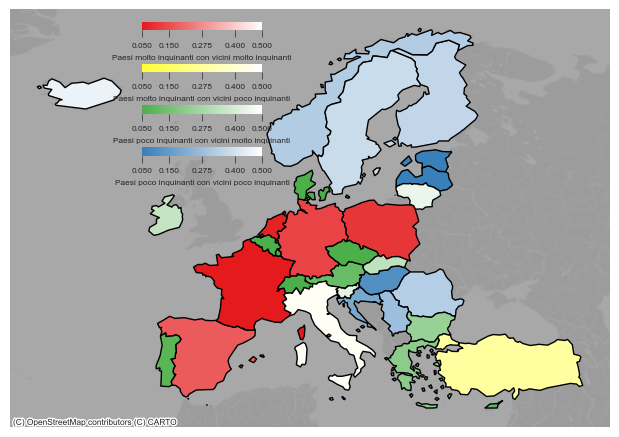

In [28]:
def legenda(ax,cmap,y,label):
    cax = ax.inset_axes([0.22 ,y ,0.2,0.02])  
    cb = plt.colorbar(cm.ScalarMappable(norm=mcolors.Normalize(vmin=minv, vmax=maxv), cmap=cmap), cax=cax, orientation='horizontal')
    cb.set_label(label, fontsize=6)
    cb.outline.set_visible(False)
    cb.ax.tick_params(labelsize=6,length=5,width=0.5)
    cb.set_ticks([0.05, 0.15, 0.275, 0.4, 0.5])


fig,ax=plt.subplots(figsize=(6,6))
minv=0.05
maxv=0.5
colore='black'
bordo=1
HH.plot(
    ax=ax,
    column="p_sim",
    cmap=cmapHH,
    vmin=minv, vmax=maxv,
    edgecolor=colore,
    linewidth=bordo,

)
LL.plot(
    ax=ax,
    column="p_sim",
    cmap=cmapLL,
    vmin=minv, vmax=maxv,
    edgecolor=colore,
    linewidth=bordo,
)
LH.plot(
    ax=ax,
    column="p_sim",
    cmap=cmapLH,
    vmin=minv, vmax=maxv,
    edgecolor=colore,
    linewidth=bordo,
)
HL.plot(
    ax=ax,
    column="p_sim",
    cmap=cmapHL,
    vmin=minv, vmax=maxv,
    edgecolor=colore,
    linewidth=bordo,
)


ax.set_axis_off()


legenda(ax,cmapHH,0.95,"Paesi molto inquinanti con vicini molto inquinanti")
legenda(ax,cmapHL,0.85,"Paesi molto inquinanti con vicini poco inquinanti")
legenda(ax,cmapLH,0.75,"Paesi poco inquinanti con vicini molto inquinanti")
legenda(ax,cmapLL,0.65,"Paesi poco inquinanti con vicini poco inquinanti")

ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.DarkMatterNoLabels,
    crs=gdfEmissioniTGEO.crs,            
    alpha=0.4,
    attribution_size=6
)
ax.margins(0)
ax.set_position([0,0,1,1])          
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
fig.savefig("Grafici/LisaMap.svg",format="svg")

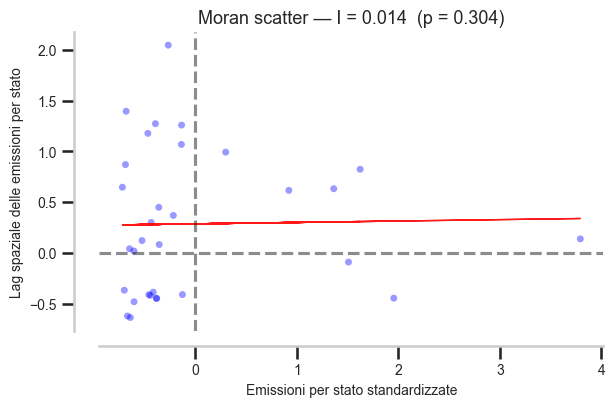

In [18]:
Moran=esda.Moran(gdfEmissioniTGEO['T_STD'],w,permutations=5000)
fig,ax=moran_scatterplot(Moran)
pts=ax.collections[0]
sz = pts.get_sizes()
pts.set_sizes(np.full_like(sz, 25))   # marker ~ 18
pts.set_alpha(0.4)
pts.set_edgecolor("none")
pts.set_facecolor("blue")
ln = ax.lines[0]
ln.set_color("red")
ln.set_linewidth(1)
ax.grid(False)
ax.set_xlabel("Emissioni per stato standardizzate", fontsize=10)
ax.set_ylabel("Lag spaziale delle emissioni per stato", fontsize=10)
ax.tick_params(labelsize=10)
ax.set_title(f"Moran scatter — I = {Moran.I:.3f}  (p = {Moran.p_sim:.3g})",
             fontsize=13)
sns.despine(ax=ax, top=True, right=True)
fig.set_size_inches(6.5, 6.5)
fig.savefig("Grafici/Moran_scatter.svg")

In [19]:
gdfDensità=gpd.GeoDataFrame(gdfDensità)

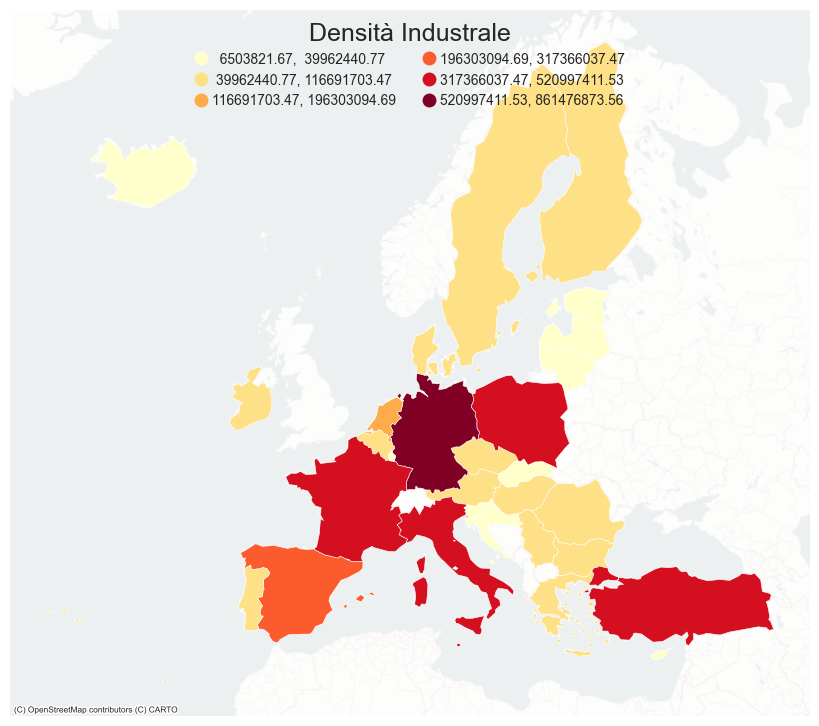

In [26]:
mask = gpd.GeoSeries([box(-30, 32, 50, 80)], crs="EPSG:4326")
gdfDensità = gdfDensità[gdfDensità.intersects(mask.iloc[0])].copy()
gdfDensità["geometry"] = gdfDensità.geometry.intersection(mask.iloc[0])

fig, ax = plt.subplots(figsize=(8, 8))
g = gdfDensità.to_crs(3857).plot(
    column="T",
    scheme="fisher_jenks", 
    k=6,
    cmap="YlOrRd",                
    linewidth=0.4, edgecolor="white",
    legend=True, ax=ax,
    legend_kwds=dict(
        title="Densità Industrale",
        loc="upper center",
        frameon=False,
        ncol=2,
        fontsize=10,          
        handlelength=0.8,     
        handletextpad=0.4,    
        borderpad=0.4,        
        labelspacing=0.5     
    ),
    missing_kwds=dict(color="#f0f0f0", edgecolor="lightgray",
                      hatch="///", label="Dati mancanti")
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels,
                alpha=0.4,   
                attribution_size=6)

ax.set_axis_off()
leg = ax.get_legend()
leg.get_frame().set_linewidth(2)
ax.margins(0)
ax.set_position([0,0,1,1])          
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.savefig("Grafici/DensitàIndustriale.svg",format="svg")

/var/folders/rc/xlbbg4d5605gwwrs3d2h21yh0000gn/T/ipykernel_36229/3777211868.py:63: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, top=1, bottom=0)


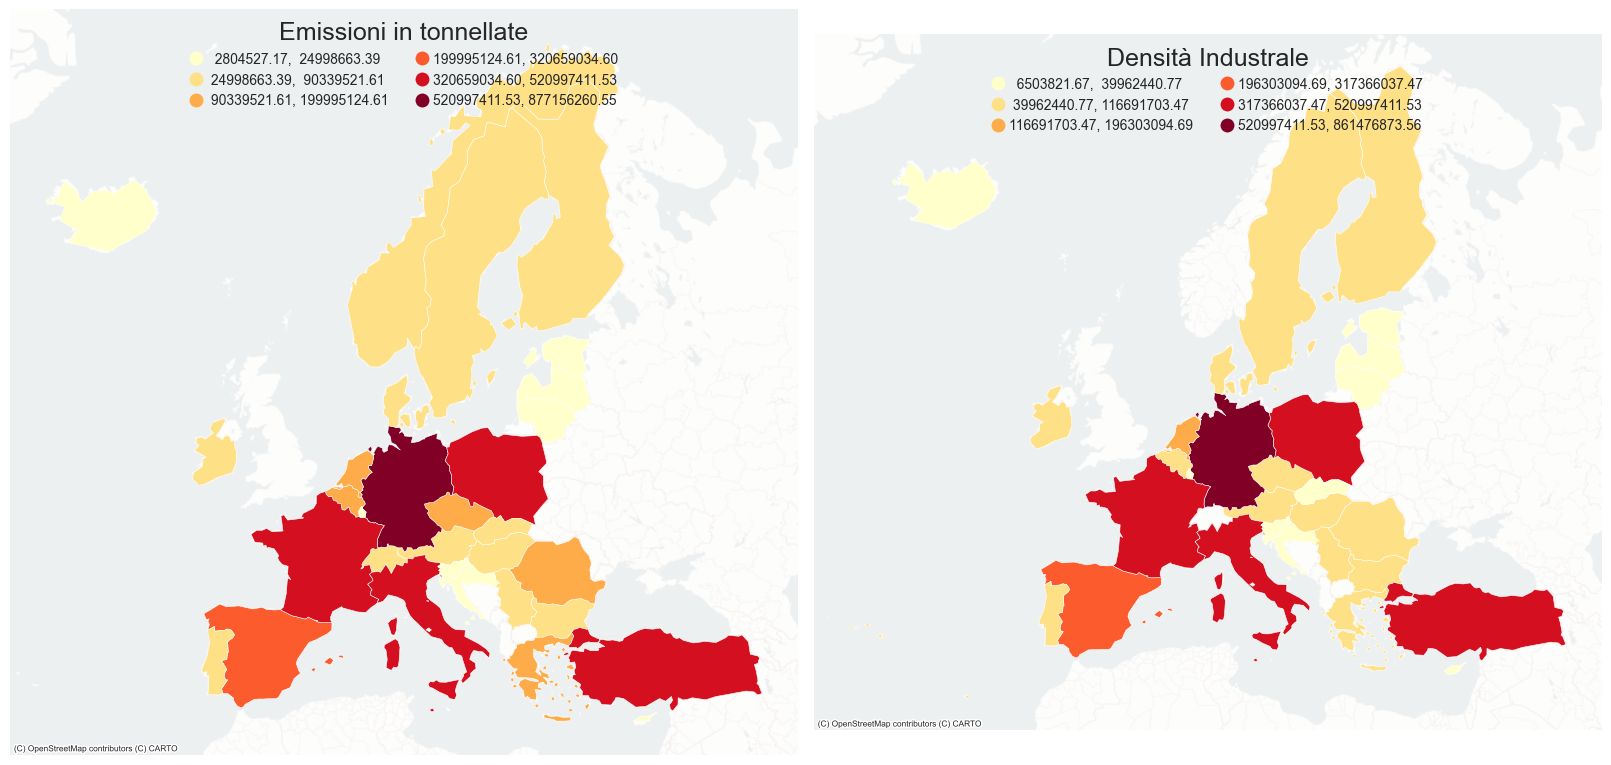

In [32]:
fig, ax = plt.subplots(1,2 ,figsize=(16, 8),constrained_layout=True)

g1 = gdfEmissioniTGEO.to_crs(3857).plot(
    column="T",
    scheme="fisher_jenks", 
    k=6,
    cmap="YlOrRd",                
    linewidth=0.4, edgecolor="white",
    legend=True, ax=ax[0],
    legend_kwds=dict(
        title="Emissioni in tonnellate",
        loc="upper center",
        frameon=False,
        ncol=2,
        fontsize=10,          
        handlelength=0.8,     
        handletextpad=0.4,    
        borderpad=0.4,        
        labelspacing=0.5     
    ),
    missing_kwds=dict(color="#f0f0f0", edgecolor="lightgray",
                      hatch="///", label="Dati mancanti")
)
ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.PositronNoLabels,
                alpha=0.4,   
                attribution_size=6)

ax[0].set_axis_off()
leg = ax[0].get_legend()
leg.get_frame().set_linewidth(2) 



g2 = gdfDensità.to_crs(3857).plot(
    column="T",
    scheme="fisher_jenks", 
    k=6,
    cmap="YlOrRd",                
    linewidth=0.4, edgecolor="white",
    legend=True, ax=ax[1],
    legend_kwds=dict(
        title="Densità Industrale",
        loc="upper center",
        frameon=False,
        ncol=2,
        fontsize=10,          
        handlelength=0.8,     
        handletextpad=0.4,    
        borderpad=0.4,        
        labelspacing=0.5     
    ),
    missing_kwds=dict(color="#f0f0f0", edgecolor="lightgray",
                      hatch="///", label="Dati mancanti")
)
ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.PositronNoLabels,
                alpha=0.4,   
                attribution_size=6)
ax[1].set_axis_off()
leg2 = ax[1].get_legend()
leg2.get_frame().set_linewidth(2)  
ax[0].margins(0)
ax[1].margins(0)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.savefig("Grafici/ConfrontoDensitàIndustrialeEdEmissioni.svg",format="svg")